In [ ]:
!nvidia-smi

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

^C


In [ ]:
!ls pubmed-rct

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'/train.txt')
train_lines[:20]

In [ ]:
len(train_lines)

In [ ]:
def preprocess_text(filename):
  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace() :
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_lines_split = abstract_line.split('\t')
        line_data['target'] = target_lines_split[0]
        line_data['text'] = target_lines_split[1].lower()
        line_data['number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split)
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples






In [ ]:
train_samples = preprocess_text(data_dir + "/train.txt")
val_samples = preprocess_text(data_dir + "/dev.txt")
test_samples = preprocess_text(data_dir + "/test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

In [ ]:
train_samples[:13]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df

In [ ]:
train_df['target'].value_counts()

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())

In [ ]:
train_labels_encoded

In [ ]:
print(label_encoder.classes_)
print(len(label_encoder.classes_))


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
     ("clf",MultinomialNB())
])

model0.fit(train_sentences,train_labels_encoded)

In [ ]:
baseline_scores = model0.score(val_sentences,val_labels_encoded)
baseline_scores

In [ ]:
baseline_preds = model0.predict(val_sentences)
baseline_preds

In [ ]:
import tensorflow as tf
print(round(sum( [ len(sen.split()) for sen in train_sentences]))/len(train_sentences))

In [ ]:
import numpy as np
# ehats the maximum value of 95% daata
seq_len = np.percentile([len(sen.split()) for sen in train_sentences], 95)
seq_len

In [ ]:
max_length = 55
max_vocab_length = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                 output_mode = 'int',
                                 output_sequence_length = max_length)



In [ ]:
import random
text_vectorizer.adapt(train_sentences)


In [ ]:
ran_sen = random.choice(train_sentences)
print(ran_sen)
print(len(ran_sen.split()))
text_vectorizer([ran_sen])


In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
print(len(words_in_vocab))
print(words_in_vocab[:5])
print(words_in_vocab[-5:])

In [ ]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim = len(words_in_vocab),
                            output_dim = 128,
                            name='embedding')

In [ ]:
print(ran_sen)
vectorized = text_vectorizer([ran_sen])
print(vectorized)
print(embedding(vectorized))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

len(train_dataset)

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset

In [ ]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32,
                  kernel_size=5,
                  strides=1,
                  activation="relu",
                  padding="same")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)

model1 = tf.keras.Model(inputs,outputs,name="model1")


In [ ]:
model1.summary()

In [ ]:
model1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
len(train_dataset)

In [ ]:
history1 = model1.fit(train_dataset,
           epochs=3,
           steps_per_epoch = int(0.1*len(train_dataset)),
           validation_data = val_dataset,
           validation_steps = int(0.1*len(val_dataset)))

In [ ]:
model1.evaluate(val_dataset)

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="usc")

In [ ]:
inputs = layers.Input(shape=(),dtype="string")
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)
model2 = tf.keras.Model(inputs,outputs,name="model2")

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
history2 = model2.fit(train_dataset,
           epochs=3,
           steps_per_epoch = int(0.1*len(train_dataset)),
           validation_data = val_dataset,
           validation_steps = int(0.1*len(val_dataset)))

In [ ]:
model2.evaluate(val_dataset)

In [ ]:
def split_chars(text):
  return " ".join([char for char in text])

print(split_chars("I love coding"))

In [ ]:
train_chars = [split_chars(sen) for sen in train_sentences]
test_chars = [split_chars(sen) for sen in test_sentences]
val_chars = [split_chars(sen) for sen in val_sentences]
train_chars[:5]

In [ ]:
char_lens = [len(sen) for sen in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens)

In [ ]:
import numpy as np
output_seq = int(np.percentile(char_lens,95))
output_seq

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)
max_char_tokens = len(alphabet) + 2 #space and oov

In [ ]:
char_vectorizer = TextVectorization(max_tokens=max_char_tokens,
                                    output_mode = 'int',
                                    output_sequence_length=output_seq)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[-5:])

In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 30
                              )

In [ ]:
ex = "I love coding"
char_vector = char_vectorizer([split_chars(ex)])
print(char_vector)
char_embed(char_vector)

In [ ]:
inputs = layers.Input(shape=(1,),dtype="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64,kernel_size=5,padding='same',activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="relu")(x)
outputs = layers.Dense(5,activation="softmax")(x)

model2 = tf.keras.Model(inputs,outputs)


In [ ]:
model2.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
model2.summary()

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32)
train_char_dataset

In [ ]:
model2_history = model2.fit(train_char_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            validation_data = val_char_dataset,
                            validation_steps = int(0.1*len(val_char_dataset)))

In [ ]:
token_inputs = layers.Input(shape=[],dtype="string")
x = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(x)
token_model = tf.keras.Model(token_inputs,token_outputs)


In [ ]:
char_inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bilstm)

In [ ]:
token_char_concat = layers.Concatenate()([token_model.output,char_model.output])

In [ ]:
combined_dense = layers.Dense(128,activation="relu")(token_char_concat)
dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5,activation="softmax")(dropout)

model3 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                        outputs=output_layer)

In [ ]:
model3.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3)

In [ ]:
model3.compile(loss='categorical_crossentropy',
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [ ]:
# prefetching is done in cpu and run on gpu
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_label = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_label))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # order must be same as u create the order in inputs model
val_char_token_label = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_label))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model3_history = model3.fit(train_char_token_dataset,
           steps_per_epoch=int(0.1*len(train_char_token_dataset)),
           epochs=3,
           validation_data=val_char_token_dataset,
           validation_steps=int(0.1*len(val_char_token_dataset)))

In [ ]:
train_df["number"].value_counts()


In [ ]:
np.percentile(train_df["number"],97)

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["number"].to_numpy() , depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["number"].to_numpy() , depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["number"].to_numpy() , depth=15)

train_line_numbers_one_hot[:10]

In [ ]:
train_df["total_lines"].value_counts()

In [ ]:
type(list(train_df['total_lines']))

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"],depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"],depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"],depth=20)

train_total_lines_one_hot[:10]

In [ ]:
token_inputs = layers.Input(shape=[],dtype="string")
x = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(x)
token_model =  tf.keras.Model(token_inputs,token_outputs)

char_inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bilstm)

line_number_input = layers.Input(shape=(15,),dtype=tf.float32)
x = layers.Dense(128,activation="relu")(line_number_input)
line_number_model = tf.keras.Model(line_number_input,x)

total_lines_input = layers.Input(shape=(20,),dtype=tf.float32)
x = layers.Dense(128,activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input,x)


combined_embeddings = layers.Concatenate()([token_model.output , char_model.output])
x = layers.Dense(256,activation="relu")(combined_embeddings)
x = layers.Dropout(0.5)(x)
combined_embeddings2 = layers.Concatenate()([line_number_model.output,total_lines_model.output,x])

output_layer = layers.Dense(5,activation="softmax")(combined_embeddings2)

model4 = tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input] ,
                        outputs = [output_layer])


In [ ]:
model4.summary()

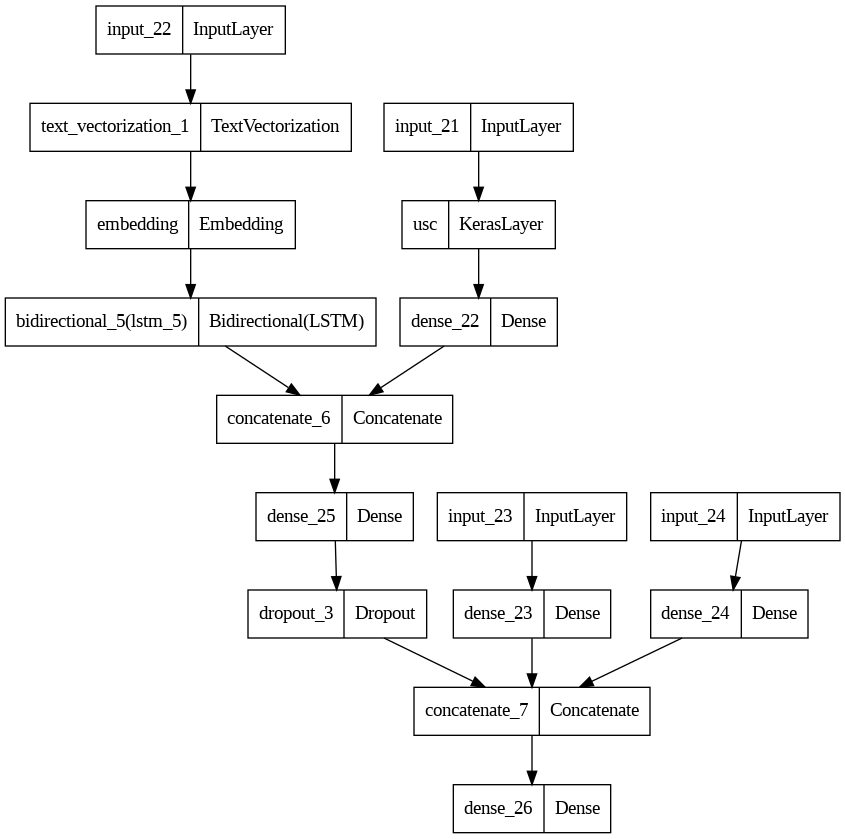

In [99]:
plot_model(model4)

In [100]:
model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

#really confident model = [0,0,1,0,0] it may not learn other
#label smoothing assigns some of value from highest pred prob to other class and helps generalisation [0.01,0.01,0.96,0.01,0.01]

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices([train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars])
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip(train_char_token_pos_data,train_char_token_pos_labels)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices([val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars])
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip(val_char_token_pos_data,train_char_token_pos_labels)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
model4_history = model4.fit(train_char_token_pos_dataset,
           epochs=3,
           steps_per_epoch = int(0.1*(train_char_token_pos_dataset)),
           validation_data = val_char_token_pos_dataset,
           validation_steps = int(0.1*(val_char_token_pos_dataset)))
